${\Huge \text{Final algorithm comparison - artefact classification}}$ <br /><br />
${\Large \text{Pierre Guilmin}}$  
$\text{December 2018}$

**Goal:** This notebook aims to compare the most classical machine learning supervised classification algorithm of scikit-learn on the best set of features found, to perform artefact vs somatic mutations classification.

This notebook is divided in 12 parts:
* **1. Get $X$ and $y$**
* **2. Set cross-validations strategies and load some modules**
* **3. Uniform**
* **4. Most Frequent**
* **5. Gaussian Naive Bayes**
* **6. Ridge Regression ($\ell_2$ regularisation)**
* **7. Lasso Regression ($\ell_1$ regularisation)**
* **8. $k$ Nearest Neigbors**
* **9. Support Vector Machine**
* **10. Random Forest**
* **11. Gradient Boosting**
* **12. Summary**

***

In [1]:
%run ../../../utils/Python/setup_environment.ipy
%run ../../../utils/Python/selene_job.ipy

Selene_Job.cluster_username             = 'guilminp'
Selene_Job.ssh_remote_jobs_cluster_path = '/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs'
Selene_Job.ssh_remote_jobs_local_path   = 'ssh_remote_jobs'

Setup environment... done!


<span style="color:green">✅ Working on **imp-ann_env** conda environment.</span>

# Get $X$ and $y$

In [2]:
data = Impact_Wrapper('../../../data/processed/annotated_final_IMPACT_mutations_20181105.txt', 'is_artefact')

In [3]:
# strand_ratio
dd = data.impact[['t_alt_neg_count', 't_alt_plus_count']].min(axis=1) / data.impact[['t_alt_neg_count', 't_alt_plus_count']].max(axis=1)
data.add_features('strand_ratio', dd, False)

In [4]:
# base_change
def switch_base(base):
    if base == 'G':
        return 'C'
    elif base == 'C':
        return 'G'
    elif base == 'A':
        return 'T'
    elif base == 'T':
        return 'A'

def get_base_change(mutation):
    if mutation['VEP_VARIANT_CLASS'] != 'SNV':
        return 'not_SNV'
    else:
        ref = mutation['Reference_Allele']
        alt = mutation['Tumor_Seq_Allele2']
        
        
        if mutation['Reference_Allele'] == 'G' or mutation['Reference_Allele'] == 'A' :
            ref = switch_base(ref)
            alt = switch_base(alt)
        
        return '{}>{}'.format(ref, alt)
    
dd = data.impact.apply(get_base_change, axis=1)
data.add_features('base_change', dd, True)

In [5]:
# reduced_VEP_SYMBOL
gene_table = get_table(data.impact['VEP_SYMBOL'])
gene_table = gene_table[gene_table['count_'] >= 1000]

def get_reduced_gene(gene):
    if gene in gene_table.index:
        return gene
    else:
        return 'other'

dd = data.impact['VEP_SYMBOL'].apply(get_reduced_gene)
data.add_features('reduced_VEP_SYMBOL', dd, True)

In [7]:
features = [
    
    # NGS
    't_depth', 't_vaf', 't_alt_count',
    'n_depth', 'n_vaf', 'n_alt_count',
    't_ref_plus_count', 't_ref_neg_count', 't_alt_plus_count', 't_alt_neg_count',
    'sample_coverage',
    
    # genome
    'Chromosome', 'VEP_VARIANT_CLASS',
    
    # freq
    'frequency_in_normals',
    
    # somatic-driver
    'VEP_COSMIC_CNT', 'is_a_hotspot', 'is_a_3d_hotspot', 'oncogenic',

    # consequence
    'gene_type', 'VEP_Consequence', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_SIFT_class', 'VEP_PolyPhen_class',

    # AF
    'VEP_gnomAD_AF', 'VEP_in_dbSNP',
    
    # new features
    'strand_ratio', 'base_change', 'reduced_VEP_SYMBOL'
]

print(len(features))

X, y = data.process(features).get_X_and_y('all', 'all')
Impact_Wrapper.print_info(X, y)

29
X: (225022, 133) | y: (225022,)


,count_,freq_
False,218173,96.96%
True,6849,3.04%


In [8]:
X.head()

,t_depth,t_vaf,t_alt_count,n_depth,n_vaf,n_alt_count,t_ref_plus_count,t_ref_neg_count,t_alt_plus_count,t_alt_neg_count,sample_coverage,frequency_in_normals,VEP_COSMIC_CNT,VEP_gnomAD_AF,strand_ratio,Chromosome_1,Chromosome_10,Chromosome_11,Chromosome_12,Chromosome_13,Chromosome_14,Chromosome_15,Chromosome_16,Chromosome_17,Chromosome_18,Chromosome_19,Chromosome_2,Chromosome_20,Chromosome_21,Chromosome_22,Chromosome_3,Chromosome_4,Chromosome_5,Chromosome_6,Chromosome_7,Chromosome_8,Chromosome_9,Chromosome_X,VEP_Consequence_frameshift_variant,VEP_Consequence_inframe_deletion,VEP_Consequence_inframe_insertion,VEP_Consequence_missense_variant,VEP_Consequence_splice_acceptor_variant,VEP_Consequence_splice_donor_variant,VEP_Consequence_start_lost,VEP_Consequence_stop_gained,VEP_Consequence_stop_lost,VEP_VARIANT_CLASS_SNV,VEP_VARIANT_CLASS_deletion,VEP_VARIANT_CLASS_indel,VEP_VARIANT_CLASS_insertion,VEP_VARIANT_CLASS_sequence_alteration,VEP_VARIANT_CLASS_substitution,VEP_IMPACT_HIGH,VEP_IMPACT_MODERATE,VEP_CLIN_SIG_benign,VEP_CLIN_SIG_pathogenic,VEP_CLIN_SIG_unknown,VEP_SIFT_class_deleterious,VEP_SIFT_class_deleterious_low_confidence,VEP_SIFT_class_tolerated,VEP_SIFT_class_tolerated_low_confidence,VEP_SIFT_class_unknown,VEP_PolyPhen_class_benign,VEP_PolyPhen_class_possibly_damaging,VEP_PolyPhen_class_probably_damaging,VEP_PolyPhen_class_unknown,VEP_in_dbSNP_False,VEP_in_dbSNP_True,is_a_hotspot_unknown,is_a_hotspot_yes,is_a_3d_hotspot_unknown,is_a_3d_hotspot_yes,oncogenic_Inconclusive,oncogenic_Likely Neutral,oncogenic_Likely Oncogenic,oncogenic_Oncogenic,oncogenic_Predicted Oncogenic,oncogenic_Unknown,gene_type_oncogene,gene_type_oncogene_and_tsg,gene_type_tsg,gene_type_unknown,base_change_C>A,base_change_C>G,base_change_C>T,base_change_T>A,base_change_T>C,base_change_T>G,base_change_not_SNV,reduced_VEP_SYMBOL_APC,reduced_VEP_SYMBOL_ARID1A,reduced_VEP_SYMBOL_ARID1B,reduced_VEP_SYMBOL_ARID2,reduced_VEP_SYMBOL_ATM,reduced_VEP_SYMBOL_ATRX,reduced_VEP_SYMBOL_BRAF,reduced_VEP_SYMBOL_BRCA2,reduced_VEP_SYMBOL_CDH1,reduced_VEP_SYMBOL_CDKN2A,reduced_VEP_SYMBOL_CREBBP,reduced_VEP_SYMBOL_DNMT3A,reduced_VEP_SYMBOL_EGFR,reduced_VEP_SYMBOL_EP300,reduced_VEP_SYMBOL_EPHA5,reduced_VEP_SYMBOL_ERBB4,reduced_VEP_SYMBOL_FAT1,reduced_VEP_SYMBOL_FBXW7,reduced_VEP_SYMBOL_GRIN2A,reduced_VEP_SYMBOL_KMT2A,reduced_VEP_SYMBOL_KMT2B,reduced_VEP_SYMBOL_KMT2C,reduced_VEP_SYMBOL_KMT2D,reduced_VEP_SYMBOL_KRAS,reduced_VEP_SYMBOL_MED12,reduced_VEP_SYMBOL_MGA,reduced_VEP_SYMBOL_NF1,reduced_VEP_SYMBOL_NOTCH1,reduced_VEP_SYMBOL_NOTCH3,reduced_VEP_SYMBOL_NOTCH4,reduced_VEP_SYMBOL_PIK3CA,reduced_VEP_SYMBOL_PTEN,reduced_VEP_SYMBOL_PTPRD,reduced_VEP_SYMBOL_PTPRT,reduced_VEP_SYMBOL_RB1,reduced_VEP_SYMBOL_ROS1,reduced_VEP_SYMBOL_SETD2,reduced_VEP_SYMBOL_SMAD4,reduced_VEP_SYMBOL_SMARCA4,reduced_VEP_SYMBOL_SPEN,reduced_VEP_SYMBOL_TP53,reduced_VEP_SYMBOL_ZFHX3,reduced_VEP_SYMBOL_other
103945,237.0,0.22363,53.0,147.0,0.00000,0.0,87.0,97.0,31.0,22.0,433.0,0.0,0.0,0.000000,0.709677,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
178250,812.0,0.57882,470.0,386.0,0.00000,0.0,161.0,181.0,229.0,241.0,508.0,0.0,0.0,0.000000,0.950207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

# Set cross-validation strategies and load some modules

We choose stratified folds (made by preserving the percentage of samples for each class) for both outer and nested cross-validation.

In [9]:
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

In [10]:
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

In [11]:
# create summary object to holds results
summary = Summary()

# Uniform

Generates predictions uniformly at random, expected accuracy: 0.5 | expected AUC: 0.5.

In [12]:
from sklearn.dummy import DummyClassifier

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      DummyClassifier(strategy='uniform', random_state=42))

metrics = Metrics(model, X, y, cv_strategy)
metrics.print_mean()

Run model... done! (14.04s)
▴ Mean average_precision: 0.030 ± 0.000
▴ Mean roc_auc          : 0.500 ± 0.000
▴ Mean precision        : 0.030 ± 0.001
▴ Mean recall           : 0.499 ± 0.014
▴ Mean f1               : 0.057 ± 0.002
▴ Mean accuracy         : 0.500 ± 0.001


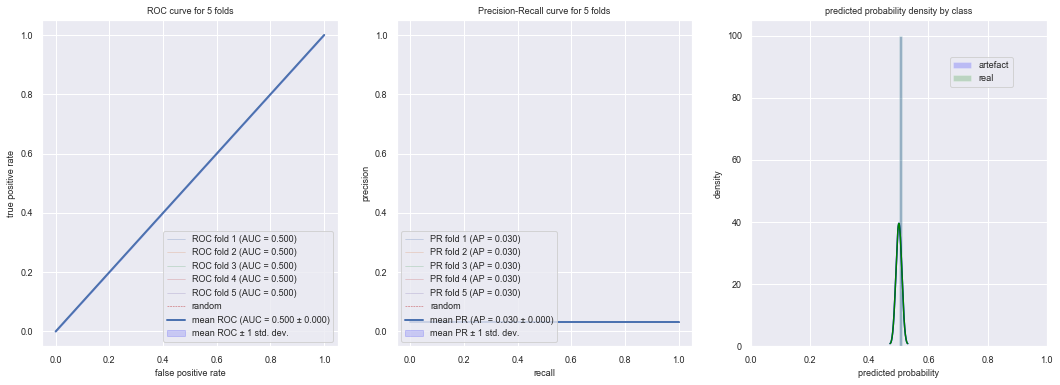

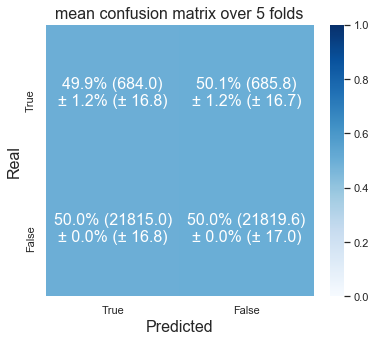

In [13]:
metrics.plot_threshold_decision_curves(figsize=(18, 6), plot_thresholds=False)
metrics.plot_mean_confusion_matrix()

In [14]:
#metrics.get_learning_curves_metrics()
#metrics.plot_learning_curves(figsize=(6, 6))

In [15]:
summary.add(metrics, 'Uniform', 'mediumseagreen')

# Most Frequent

Always predicts the most frequent label in the training set → expected accuracy: proportion of the most reccurent class in the dataset | expected AUC: 0.5

In [16]:
from sklearn.dummy import DummyClassifier
import warnings

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      DummyClassifier(strategy='most_frequent', random_state=42))

# extra lines to avoid "UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples." We know that the F1-score won't mean anything here. 
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    metrics = Metrics(model, X, y, cv_strategy)
metrics.print_mean()

Run model... done! (14.20s)
▴ Mean average_precision: 0.030 ± 0.000
▴ Mean roc_auc          : 0.500 ± 0.000
▴ Mean precision        : 0.000 ± 0.000
▴ Mean recall           : 0.000 ± 0.000
▴ Mean f1               : 0.000 ± 0.000
▴ Mean accuracy         : 0.970 ± 0.000


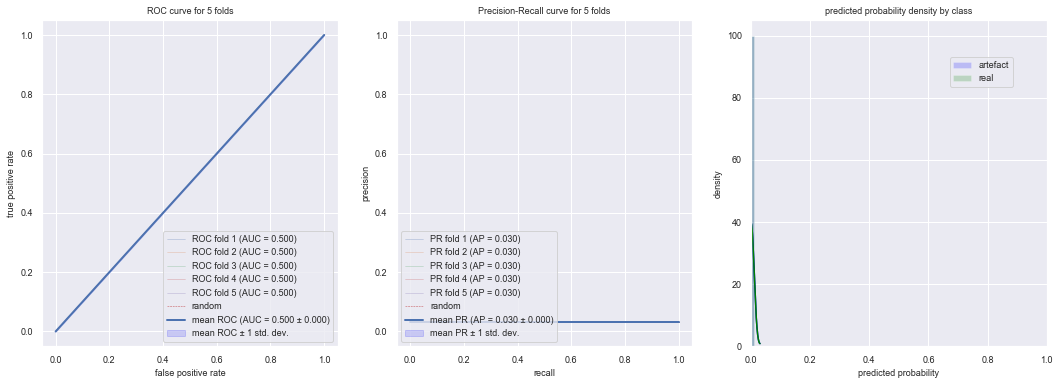

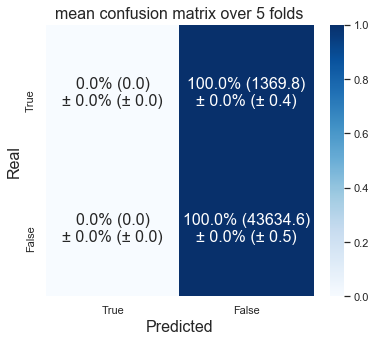

In [17]:
metrics.plot_threshold_decision_curves(figsize=(18, 6), plot_thresholds=False)
metrics.plot_mean_confusion_matrix()

In [18]:
summary.add(metrics, 'MostFrequent', 'seagreen')

# Gaussian Naive Bayes

In [19]:
from sklearn.naive_bayes import GaussianNB

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      StandardScaler(),
                      GaussianNB())

metrics = Metrics(model, X, y, cv_strategy)
metrics.print_mean()

Run model... done! (62.19s)
▴ Mean average_precision: 0.157 ± 0.008
▴ Mean roc_auc          : 0.796 ± 0.008
▴ Mean precision        : 0.086 ± 0.003
▴ Mean recall           : 0.728 ± 0.029
▴ Mean f1               : 0.154 ± 0.005
▴ Mean accuracy         : 0.757 ± 0.013


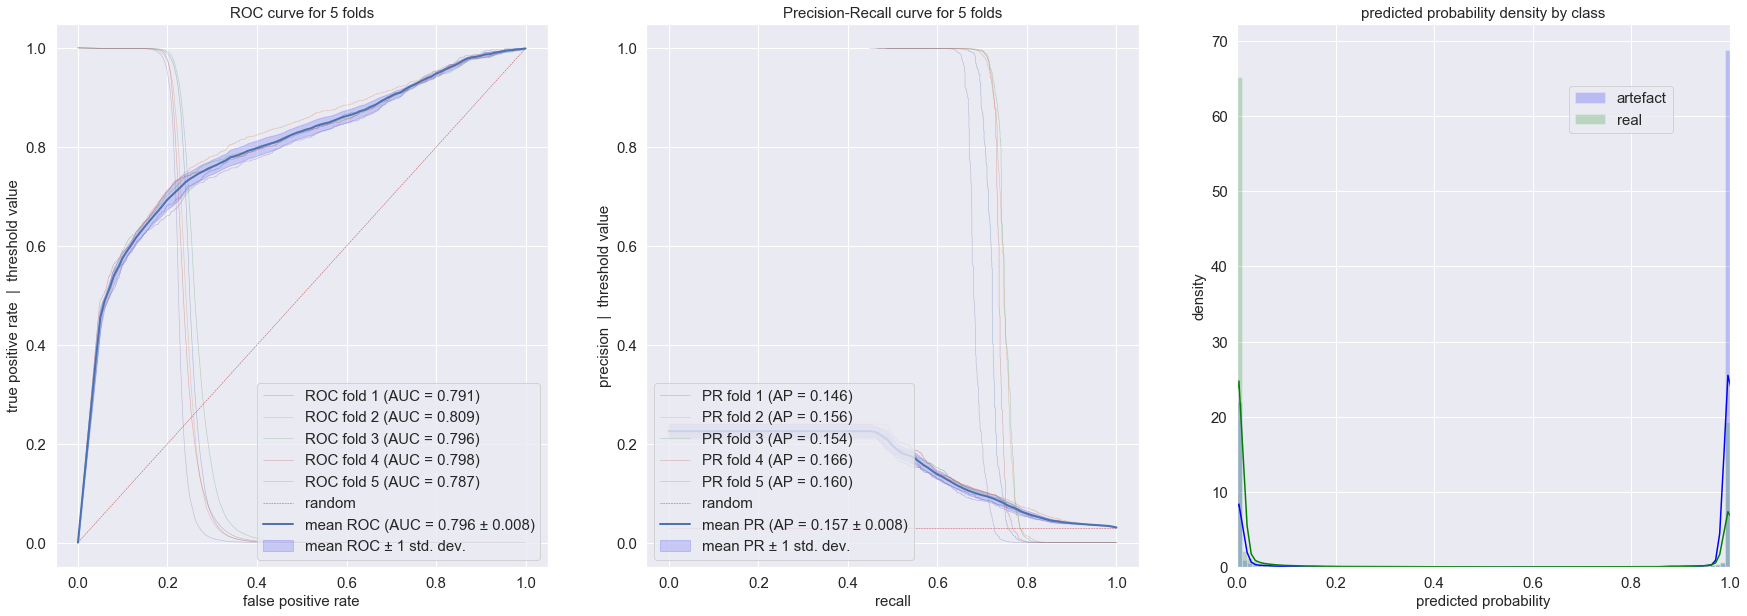

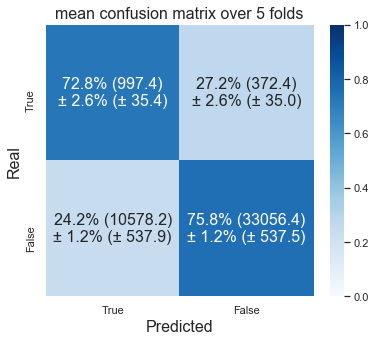

In [20]:
metrics.plot_threshold_decision_curves()
metrics.plot_mean_confusion_matrix()

In [21]:
summary.add(metrics, 'GausssianNaiveBayes', 'darkgoldenrod')

# Ridge regression ($\ell_2$ regularization)

This model performs an automatic grid search over its parameters.

In [22]:
from sklearn.linear_model import LogisticRegressionCV

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      StandardScaler(),
                      LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', random_state=42, max_iter=2000))

metrics = Metrics(model, X, y, cv_strategy)
metrics.print_mean()

Run model... done! (45.99s)
▴ Mean average_precision: 0.422 ± 0.022
▴ Mean roc_auc          : 0.871 ± 0.007
▴ Mean precision        : 0.135 ± 0.002
▴ Mean recall           : 0.721 ± 0.016
▴ Mean f1               : 0.227 ± 0.003
▴ Mean accuracy         : 0.851 ± 0.001


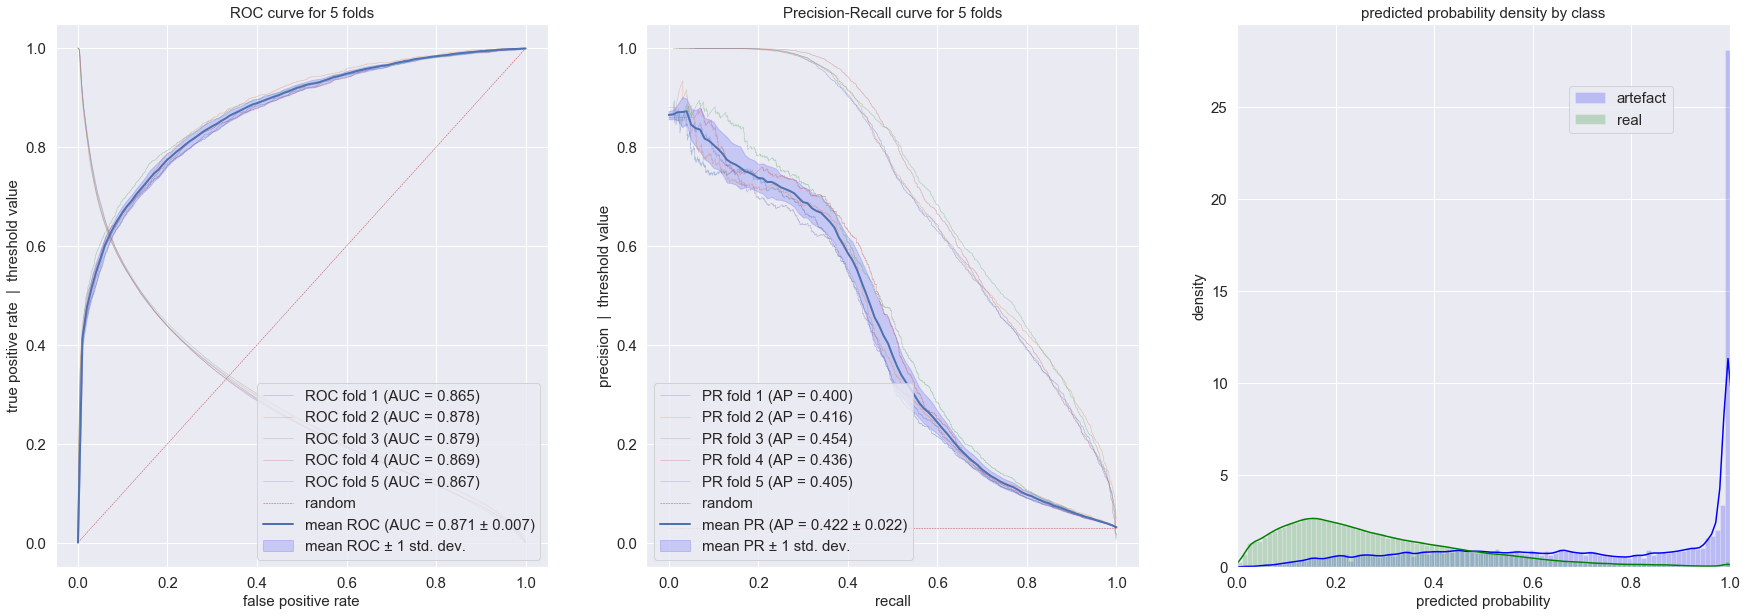

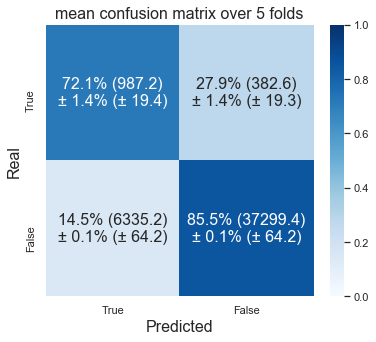

In [23]:
metrics.plot_threshold_decision_curves()
metrics.plot_mean_confusion_matrix()

In [24]:
summary.add(metrics, 'RidgeRegression', 'salmon')

"If your variables are positively correlated, then the coefficients will be negatively correlated, which can lead to a wrong sign on one of the coefficients.", see https://stats.stackexchange.com/questions/1580/regression-coefficients-that-flip-sign-after-including-other-predictors.

In [60]:
model.fit(X, y)

feature_coefficient = pd.DataFrame({'coeff': model.named_steps['logisticregressioncv'].coef_[0]}, index=X.columns.tolist())
feature_coefficient.sort_values(by='coeff', axis=0, inplace=True)

plt.figure(figsize = (12, 35))
feature_coefficient.coeff.plot.barh(width=0.85, linewidth=0);

KeyError: 'logisticregressioncv'

# Lasso regression ($\ell_1$ regularization)

In [28]:
job = Selene_Job('fac_LassoRegression')

➞ mkdir on local computer ssh_remote_jobs/job_fac_LassoRegression


<span style="color:green">Job < fac_LassoRegression >: </span>✅ created

In [29]:
job = Selene_Job('fac_LassoRegression', load_from_id=True)

<span style="color:green">Job < fac_LassoRegression >: </span>✅ job found and reloaded

In [30]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fac_LassoRegression


<span style="color:green">Job < fac_LassoRegression >: </span>✅ data loaded

In [31]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../../../../utils/python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      StandardScaler(),
                      LogisticRegressionCV(cv=nested_cv_strategy, penalty='l1', solver='liblinear', scoring='roc_auc', random_state=42, max_iter=1000))
metrics = Metrics(model, X, y, cv_strategy, n_jobs=5)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Writing ssh_remote_jobs/job_fac_LassoRegression/script.ipy


In [32]:
job.run(n_jobs=5, short_job=True)

➞ scp ssh_remote_jobs/job_fac_LassoRegression to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_fac_LassoRegression
script.ipy                                    100% 1001   156.1KB/s   00:00    
X.pkl                                         100%   64MB  15.9MB/s   00:04    
y.pkl                                         100% 3736KB  15.9MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_fac_LassoRegression
Job <30747941> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fac_LassoRegression -We 59 -n 5 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fac_LassoRegression >: </span>✅ submitted<br>

In [33]:
job.get_results()

<span style="color:red">Job < fac_LassoRegression >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

▴ Mean average_precision: 0.398 ± 0.015
▴ Mean roc_auc          : 0.841 ± 0.008
▴ Mean precision        : 0.175 ± 0.009
▴ Mean recall           : 0.636 ± 0.016
▴ Mean f1               : 0.275 ± 0.012
▴ Mean accuracy         : 0.894 ± 0.006


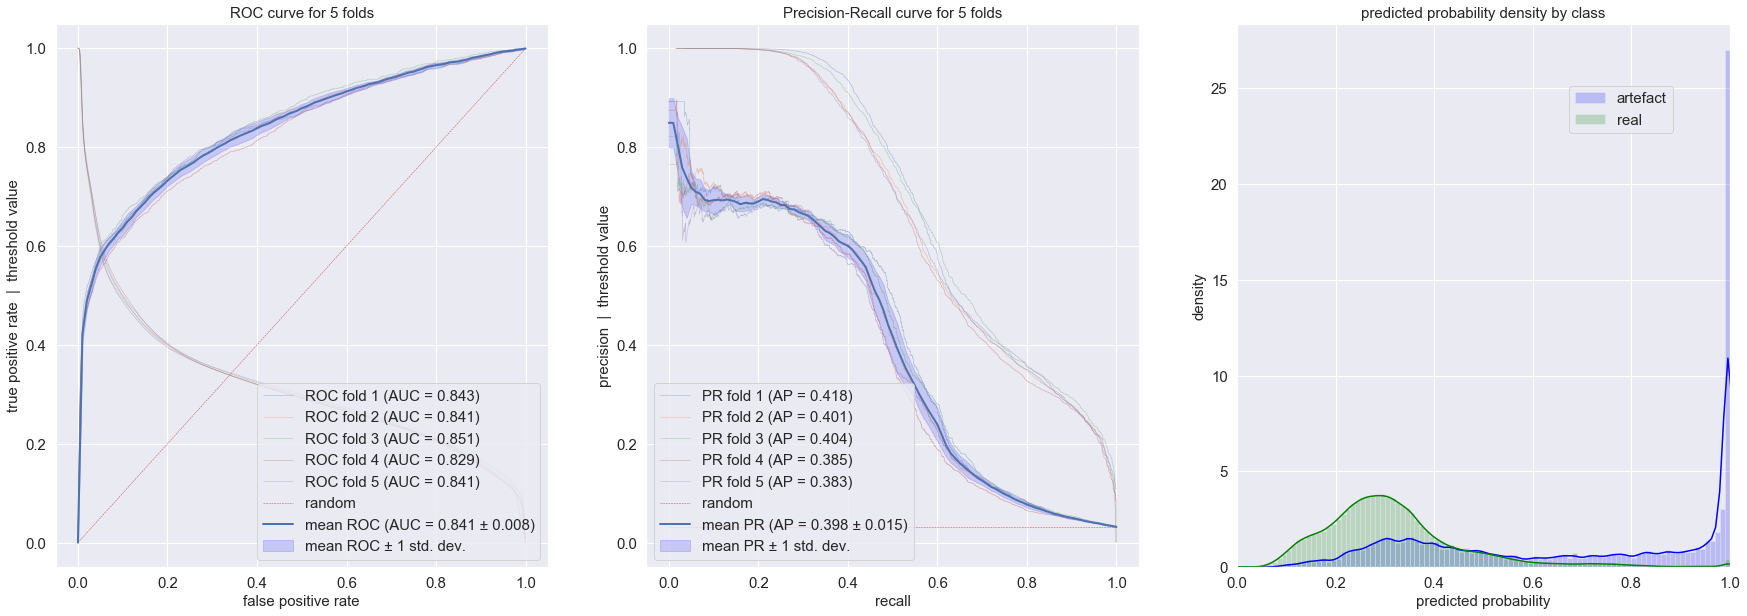

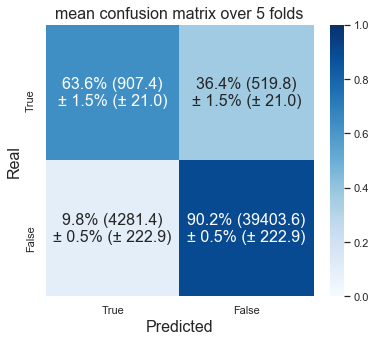

In [24]:
job.metrics.print_mean()
job.metrics.plot_threshold_decision_curves()
job.metrics.plot_mean_confusion_matrix()

In [25]:
summary.add(job.metrics, 'LassoRegression', 'crimson')

We change the regularization to make it stronger (otherwise we get the same result as for the ridge regression previously):

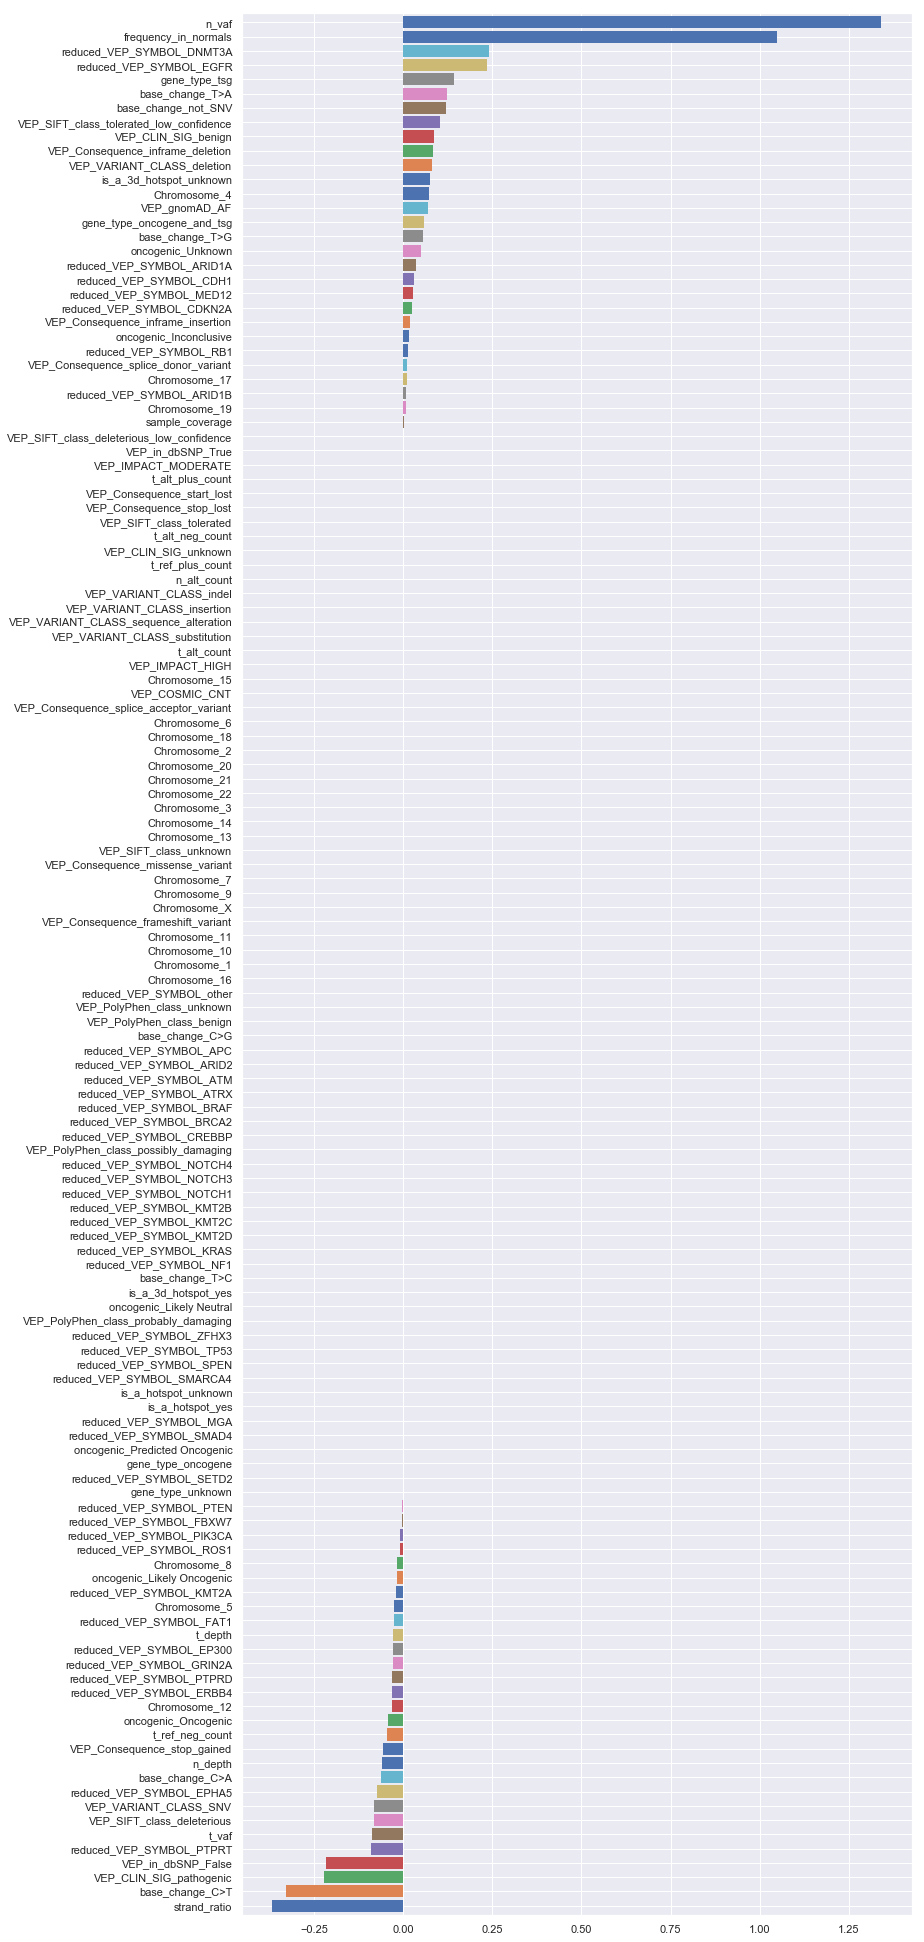

In [59]:
from sklearn.linear_model import LogisticRegression

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      StandardScaler(),
                      LogisticRegression(penalty='l1', solver='liblinear', random_state=42, C=0.01))
model.fit(X, y)

feature_coefficient = pd.DataFrame({'coeff': model.named_steps['logisticregression'].coef_[0]}, index=X.columns.tolist())
feature_coefficient.sort_values(by='coeff', axis=0, inplace=True)

plt.figure(figsize = (12, 35))
feature_coefficient.coeff.plot.barh(width=0.85, linewidth=0);

# $k$ Nearest Neighbors

In [34]:
job = Selene_Job('fac_kNN')

➞ mkdir on local computer ssh_remote_jobs/job_fac_kNN


<span style="color:green">Job < fac_kNN >: </span>✅ created

In [35]:
job = Selene_Job('fac_kNN', load_from_id=True)

<span style="color:green">Job < fac_kNN >: </span>✅ job found and reloaded

In [36]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fac_kNN


<span style="color:green">Job < fac_kNN >: </span>✅ data loaded

In [37]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../../../../utils/python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
parameters_grid = [
                    {'kneighborsclassifier__n_neighbors': [10, 15, 20, 25, 30, 40, 50, 60, 100],
                     'kneighborsclassifier__weights': ['uniform', 'distance']}
                  ]
pipe = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                     StandardScaler(),
                     KNeighborsClassifier())

model = GridSearchCV(pipe, parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = Metrics(model, X, y, cv_strategy, n_jobs=5)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Writing ssh_remote_jobs/job_fac_kNN/script.ipy


In [38]:
job.run(n_jobs=5, short_job=False)

➞ scp ssh_remote_jobs/job_fac_kNN to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_fac_kNN
script.ipy                                    100% 1278   150.2KB/s   00:00    
X.pkl                                         100%   64MB  14.1MB/s   00:04    
y.pkl                                         100% 3736KB  12.9MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_fac_kNN
Job <30747943> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fac_kNN -n 5 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fac_kNN >: </span>✅ submitted<br>

In [39]:
job.get_results()

<span style="color:red">Job < fac_kNN >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

▴ Mean average_precision: 0.391 ± 0.009
▴ Mean roc_auc          : 0.854 ± 0.006
▴ Mean precision        : 0.149 ± 0.003
▴ Mean recall           : 0.689 ± 0.009
▴ Mean f1               : 0.245 ± 0.003
▴ Mean accuracy         : 0.865 ± 0.003


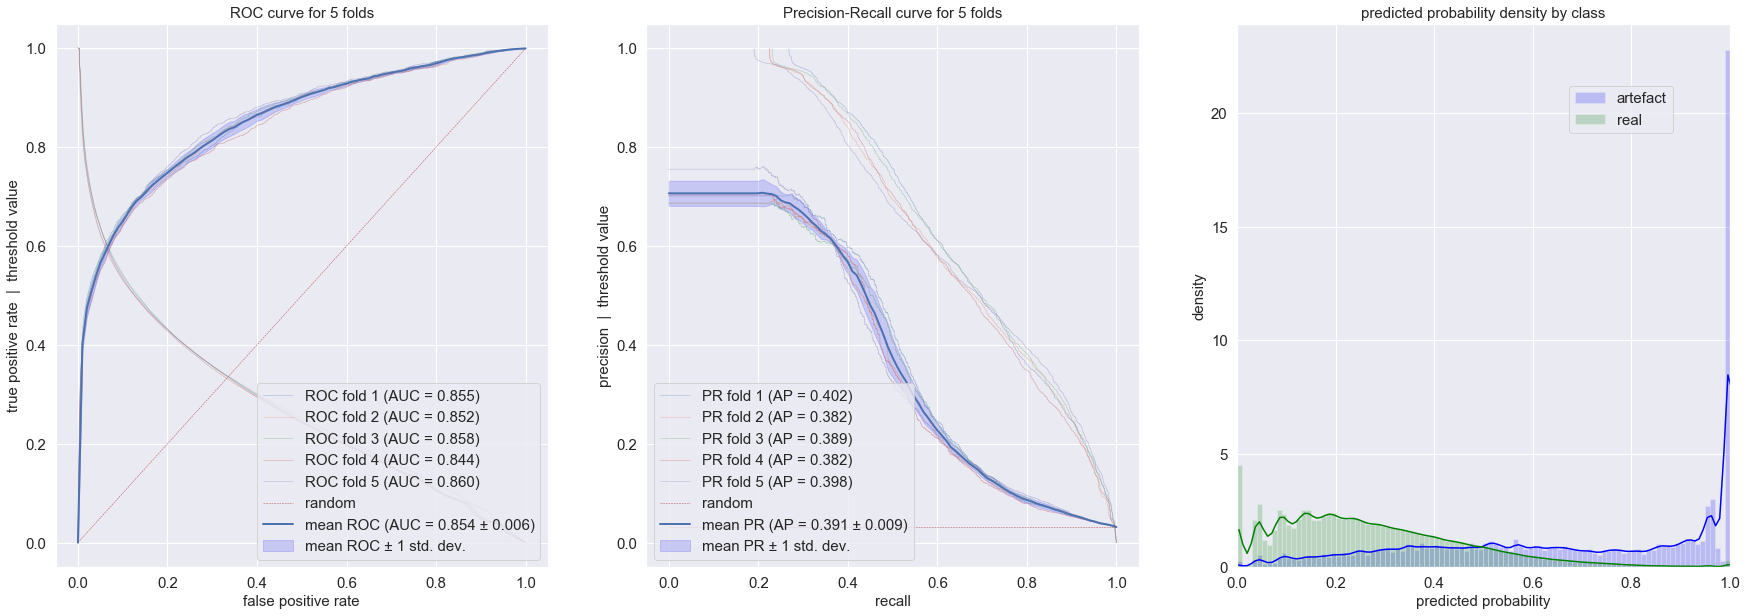

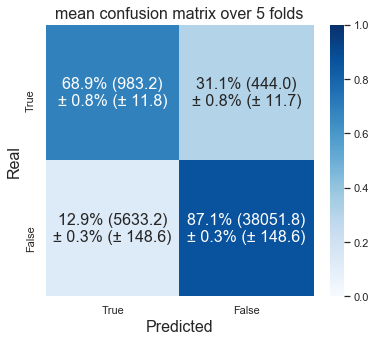

In [29]:
job.metrics.print_mean()
job.metrics.plot_threshold_decision_curves()
job.metrics.plot_mean_confusion_matrix()

2 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → kneighborsclassifier__n_neighbors: [10 15 20 25 30 40 50 60 100]
  → kneighborsclassifier__weights    : ['distance' 'uniform']
Best hyperparameters for each fold:
fold 0: {'kneighborsclassifier__n_neighbors': 20, 'kneighborsclassifier__weights': 'distance'}
fold 1: {'kneighborsclassifier__n_neighbors': 20, 'kneighborsclassifier__weights': 'distance'}
fold 2: {'kneighborsclassifier__n_neighbors': 20, 'kneighborsclassifier__weights': 'distance'}
fold 3: {'kneighborsclassifier__n_neighbors': 20, 'kneighborsclassifier__weights': 'distance'}
fold 4: {'kneighborsclassifier__n_neighbors': 25, 'kneighborsclassifier__weights': 'distance'}


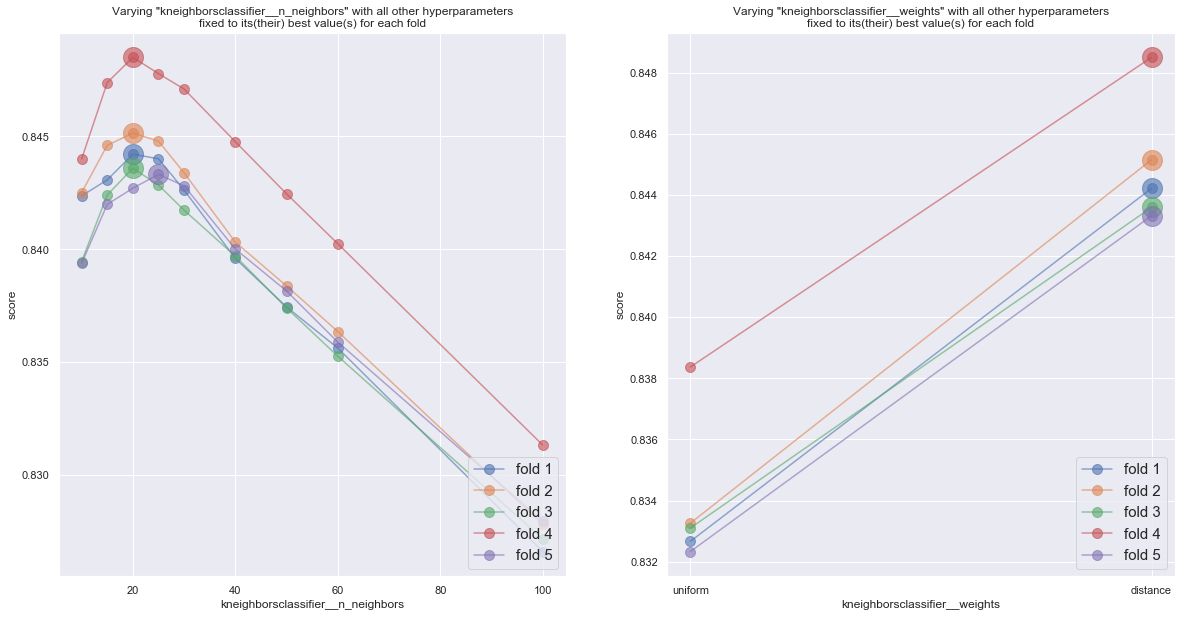

In [30]:
job.metrics.plot_grid_search_results(plot_error_bar = False)

In [31]:
summary.add(job.metrics, 'kNN', 'maroon')

# Support Vector Machine

In [40]:
job = Selene_Job('fac_SVM')

➞ mkdir on local computer ssh_remote_jobs/job_fac_SVM


<span style="color:green">Job < fac_SVM >: </span>✅ created

In [41]:
job = Selene_Job('fac_SVM', load_from_id=True)

<span style="color:green">Job < fac_SVM >: </span>✅ job found and reloaded

In [42]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fac_SVM


<span style="color:green">Job < fac_SVM >: </span>✅ data loaded

In [43]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../../../../utils/python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
parameters_grid = [
                    {'svc__C': [1, 5, 20, 30, 35, 40],
                     'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
                  ]
pipe = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                     StandardScaler(),
                     SVC(probability=True, cache_size=1000, gamma='scale'))
model = GridSearchCV(pipe, parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = Metrics(model, X, y, cv_strategy, n_jobs=5)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Writing ssh_remote_jobs/job_fac_SVM/script.ipy


In [44]:
job.run(n_jobs=5, short_job=False, memory=8)

➞ scp ssh_remote_jobs/job_fac_SVM to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_fac_SVM
script.ipy                                    100% 1238   181.6KB/s   00:00    
X.pkl                                         100%   64MB  15.9MB/s   00:04    
y.pkl                                         100% 3736KB  12.8MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_fac_SVM
Job <30747944> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fac_SVM -n 5 -R "span[ptile=5,mem=8]" "ipython script.ipy"


<span style="color:green">Job < fac_SVM >: </span>✅ submitted<br>

In [45]:
job.get_results()

<span style="color:red">Job < fac_SVM >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

▴ Mean average_precision: 0.376 ± 0.018
▴ Mean roc_auc          : 0.853 ± 0.006
▴ Mean precision        : 0.202 ± 0.014
▴ Mean recall           : 0.664 ± 0.016
▴ Mean f1               : 0.309 ± 0.016
▴ Mean accuracy         : 0.906 ± 0.007


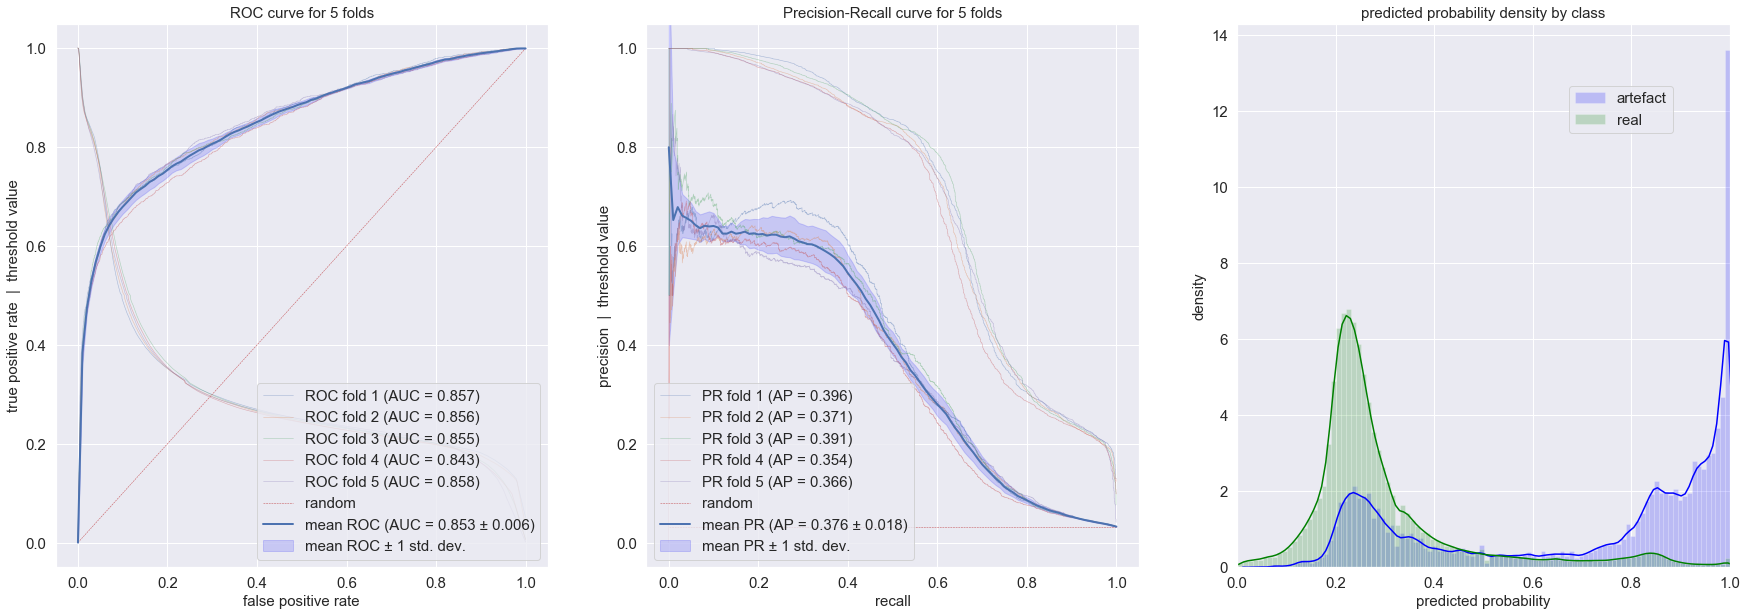

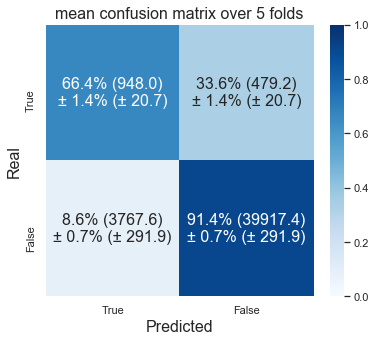

In [34]:
job.metrics.print_mean()
job.metrics.plot_threshold_decision_curves()
job.metrics.plot_mean_confusion_matrix()

2 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → svc__C     : [1 5 20 30 35 40]
  → svc__kernel: ['linear' 'poly' 'rbf' 'sigmoid']
Best hyperparameters for each fold:
fold 0: {'svc__C': 5, 'svc__kernel': 'rbf'}
fold 1: {'svc__C': 5, 'svc__kernel': 'rbf'}
fold 2: {'svc__C': 20, 'svc__kernel': 'rbf'}
fold 3: {'svc__C': 20, 'svc__kernel': 'rbf'}
fold 4: {'svc__C': 35, 'svc__kernel': 'rbf'}


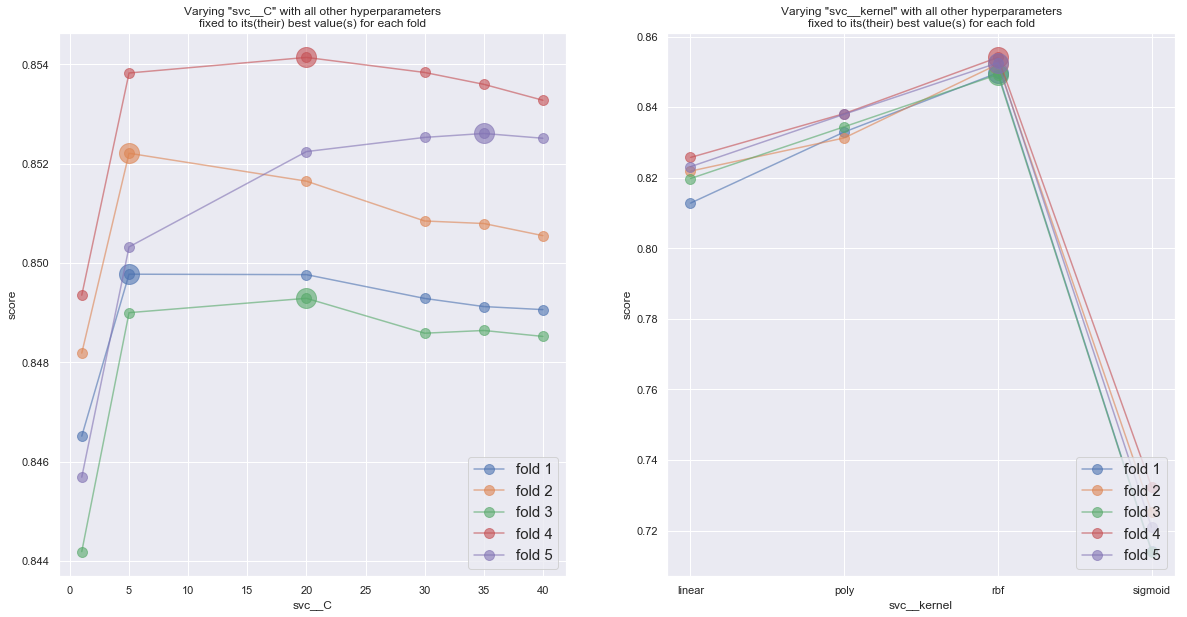

In [35]:
job.metrics.plot_grid_search_results(plot_error_bar = False)

In [36]:
summary.add(job.metrics, 'SVM', 'grey')

# Random Forest

In [46]:
job = Selene_Job('fac_RandomForest')

➞ mkdir on local computer ssh_remote_jobs/job_fac_RandomForest


<span style="color:green">Job < fac_RandomForest >: </span>✅ created

In [47]:
job = Selene_Job('fac_RandomForest', load_from_id=True)

<span style="color:green">Job < fac_RandomForest >: </span>✅ job found and reloaded

In [48]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fac_RandomForest


<span style="color:green">Job < fac_RandomForest >: </span>✅ data loaded

In [49]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../../../../utils/python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
parameters_grid = [
                    {'randomforestclassifier__n_estimators': [100, 500, 1000, 1500],
                     'randomforestclassifier__criterion': ['gini', 'entropy'],
                     'randomforestclassifier__max_depth': [15, 18, 20, 22, 25, 30, 40, 50]}
                  ]

pipe = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                     RandomForestClassifier(random_state=42))
model = GridSearchCV(pipe, parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = Metrics(model, X, y, cv_strategy, n_jobs=5)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Writing ssh_remote_jobs/job_fac_RandomForest/script.ipy


In [50]:
job.run(n_jobs=20, short_job=False, memory=32)

➞ scp ssh_remote_jobs/job_fac_RandomForest to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_fac_RandomForest
script.ipy                                    100% 1337   192.2KB/s   00:00    
X.pkl                                         100%   64MB  14.3MB/s   00:04    
y.pkl                                         100% 3736KB  16.5MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_fac_RandomForest
Job <30747945> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fac_RandomForest -n 20 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < fac_RandomForest >: </span>✅ submitted<br>

In [51]:
job.get_results()

<span style="color:red">Job < fac_RandomForest >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

▴ Mean average_precision: 0.506 ± 0.012
▴ Mean roc_auc          : 0.890 ± 0.005
▴ Mean precision        : 0.184 ± 0.005
▴ Mean recall           : 0.730 ± 0.013
▴ Mean f1               : 0.294 ± 0.006
▴ Mean accuracy         : 0.889 ± 0.003


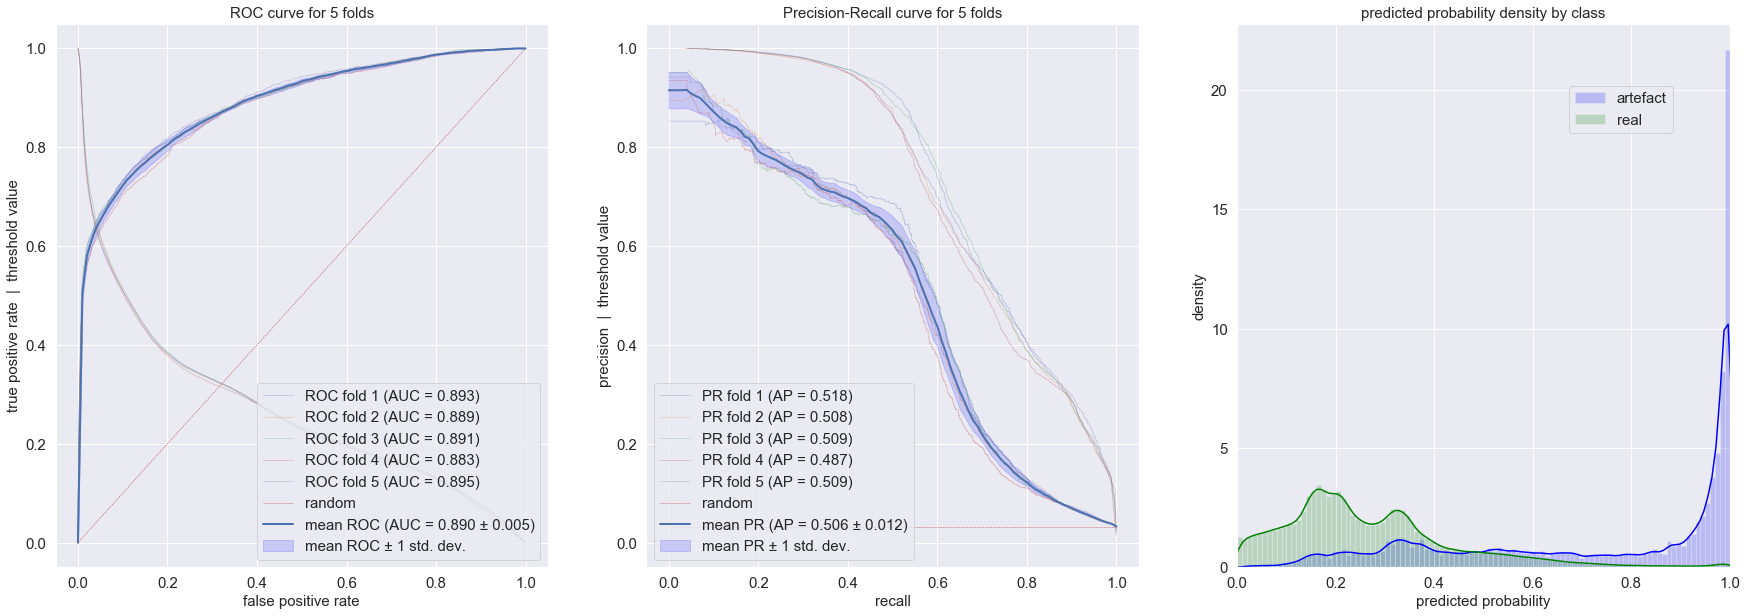

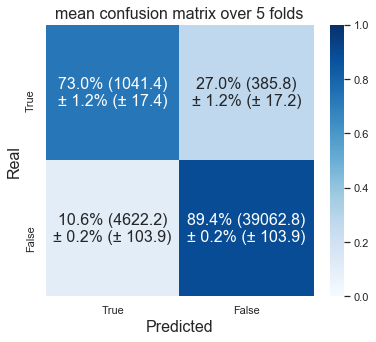

In [39]:
job.metrics.print_mean()
job.metrics.plot_threshold_decision_curves()
job.metrics.plot_mean_confusion_matrix()

3 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → randomforestclassifier__criterion   : ['entropy' 'gini']
  → randomforestclassifier__max_depth   : [15 18 20 22 25 30 40 50]
  → randomforestclassifier__n_estimators: [100 500 1000 1500]
Best hyperparameters for each fold:
fold 0: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__n_estimators': 500}
fold 1: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__n_estimators': 1500}
fold 2: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__n_estimators': 1500}
fold 3: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__n_estimators': 1500}
fold 4: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 20, 'randomforest

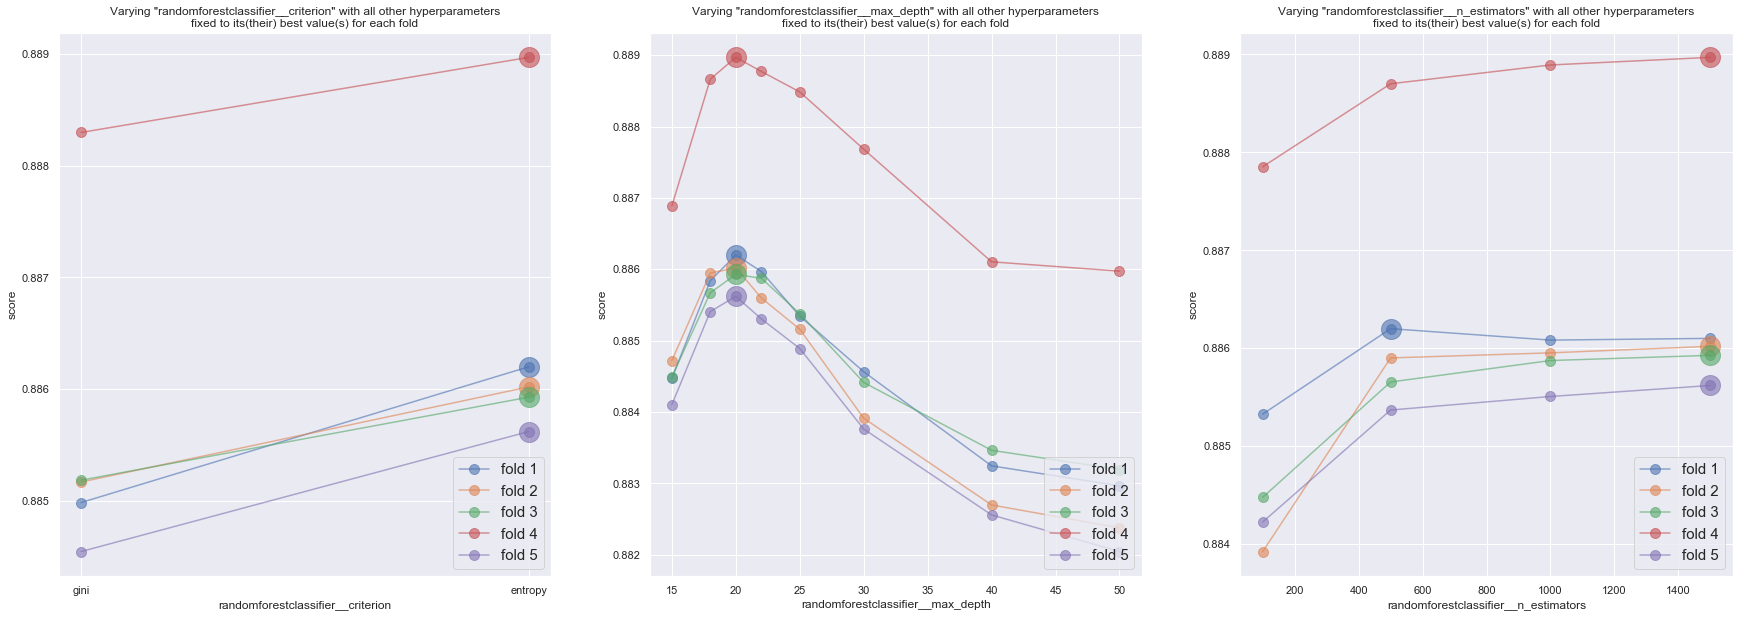

In [40]:
job.metrics.plot_grid_search_results(plot_error_bar=False)

In [41]:
summary.add(job.metrics, 'RandomForest', 'purple')

Fit model... done! (8.32s)


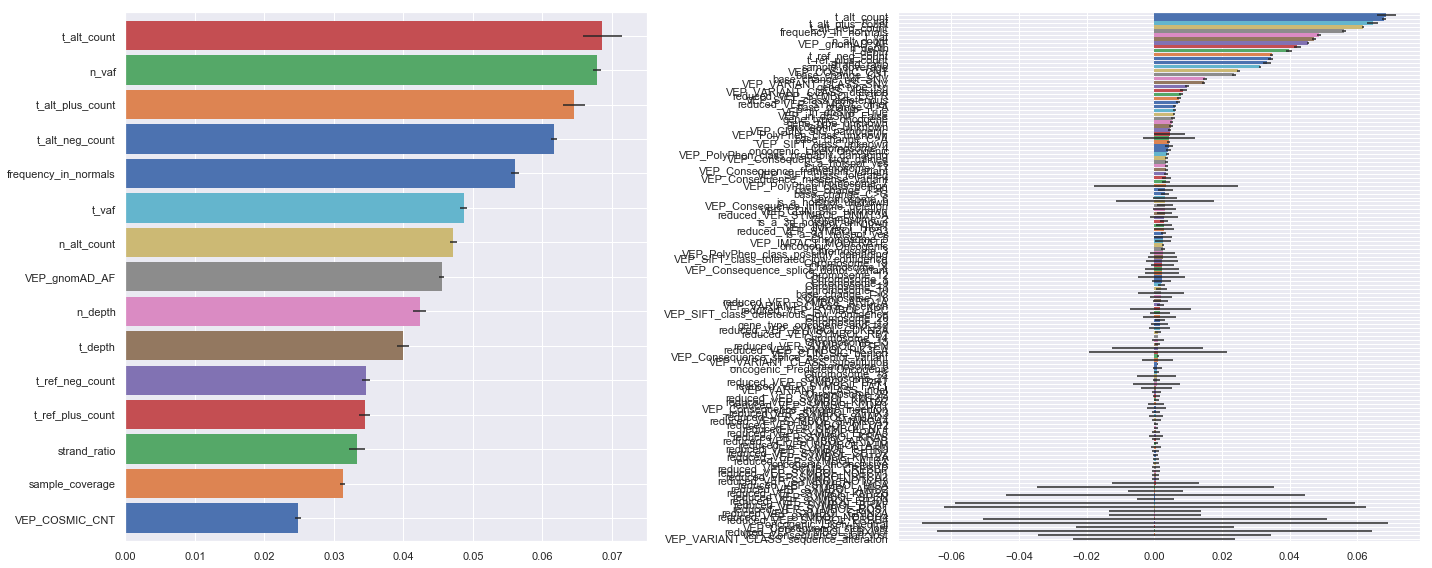

In [62]:
from sklearn.ensemble import RandomForestClassifier

model_bestRF = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                             RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=20, criterion='entropy', n_jobs=5))

metrics = Metrics(model_bestRF, X, y, cv_strategy, n_jobs=5, run_model=False)
metrics.plot_features_importance(random_forest=True, pipeline_step_index=1)

# Gradient Boosting

In [52]:
job = Selene_Job('fac_GradientBoosting')

➞ mkdir on local computer ssh_remote_jobs/job_fac_GradientBoosting


<span style="color:green">Job < fac_GradientBoosting >: </span>✅ created

In [53]:
job = Selene_Job('fac_GradientBoosting', load_from_id=True)

<span style="color:green">Job < fac_GradientBoosting >: </span>✅ job found and reloaded

In [54]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fac_GradientBoosting


<span style="color:green">Job < fac_GradientBoosting >: </span>✅ data loaded

In [55]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../../../../utils/python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
parameters_grid = [
                    {'gradientboostingclassifier__loss': ['deviance', 'exponential'],
                     'gradientboostingclassifier__learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1, 0.2],
                     'gradientboostingclassifier__n_estimators': [50, 100, 500, 800],
                     'gradientboostingclassifier__max_depth': [4, 6, 8, 10, 12, 15, 20]}
                  ]
pipe = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                     GradientBoostingClassifier(random_state=42))
model = GridSearchCV(pipe, parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = Metrics(model, X, y, cv_strategy, n_jobs=5)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Writing ssh_remote_jobs/job_fac_GradientBoosting/script.ipy


In [56]:
job.run(n_jobs=5, short_job=False, memory=8)

➞ scp ssh_remote_jobs/job_fac_GradientBoosting to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_fac_GradientBoosting
script.ipy                                    100% 1451   216.6KB/s   00:00    
X.pkl                                         100%   64MB  14.1MB/s   00:04    
y.pkl                                         100% 3736KB  12.3MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_fac_GradientBoosting
Job <30747946> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fac_GradientBoosting -n 5 -R "span[ptile=5,mem=8]" "ipython script.ipy"


<span style="color:green">Job < fac_GradientBoosting >: </span>✅ submitted<br>

In [57]:
job.get_results()

<span style="color:red">Job < fac_GradientBoosting >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

▴ Mean average_precision: 0.514 ± 0.016
▴ Mean roc_auc          : 0.892 ± 0.005
▴ Mean precision        : 0.173 ± 0.006
▴ Mean recall           : 0.748 ± 0.006
▴ Mean f1               : 0.281 ± 0.008
▴ Mean accuracy         : 0.879 ± 0.004


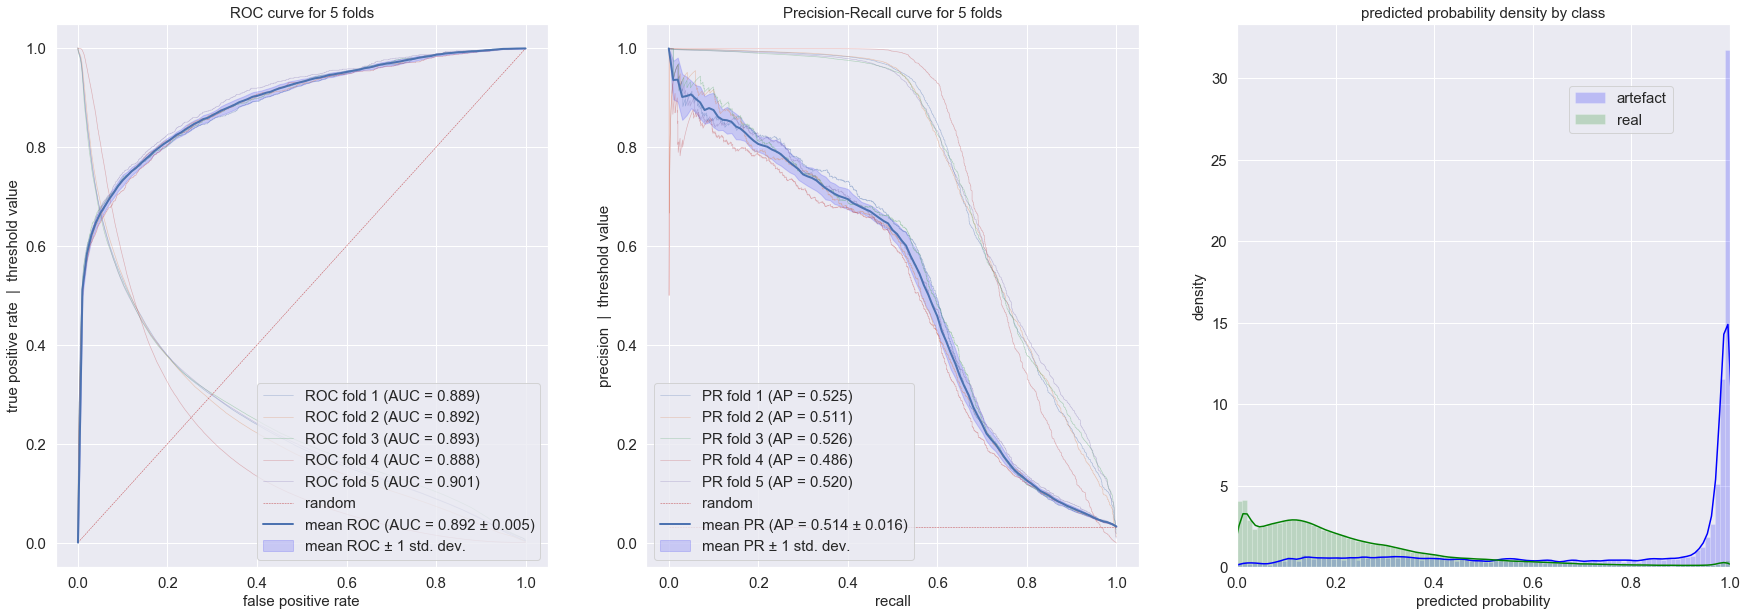

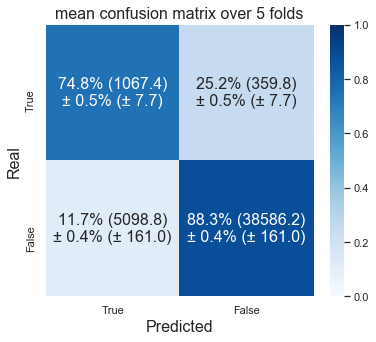

In [45]:
job.metrics.print_mean()
job.metrics.plot_threshold_decision_curves()
job.metrics.plot_mean_confusion_matrix()

4 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → gradientboostingclassifier__learning_rate: [0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0.12 0.15 0.2]
  → gradientboostingclassifier__loss         : ['deviance' 'exponential']
  → gradientboostingclassifier__max_depth    : [4 5 6 7 8 9 10 11 12 15 20]
  → gradientboostingclassifier__n_estimators : [20 50 100 500 800]
Best hyperparameters for each fold:
fold 0: {'gradientboostingclassifier__learning_rate': 0.03, 'gradientboostingclassifier__loss': 'deviance', 'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__n_estimators': 500}
fold 1: {'gradientboostingclassifier__learning_rate': 0.03, 'gradientboostingclassifier__loss': 'deviance', 'gradientboostingclassifier__max_depth': 8, 'gradientboostingclassifier__n_estimators': 500}
fold 2: {'gradientboostingclassifier__learning_rate': 0.03, 'gradientboostingclassifier__loss': 'deviance', 'gradientboostingclassifier__max_depth': 6,

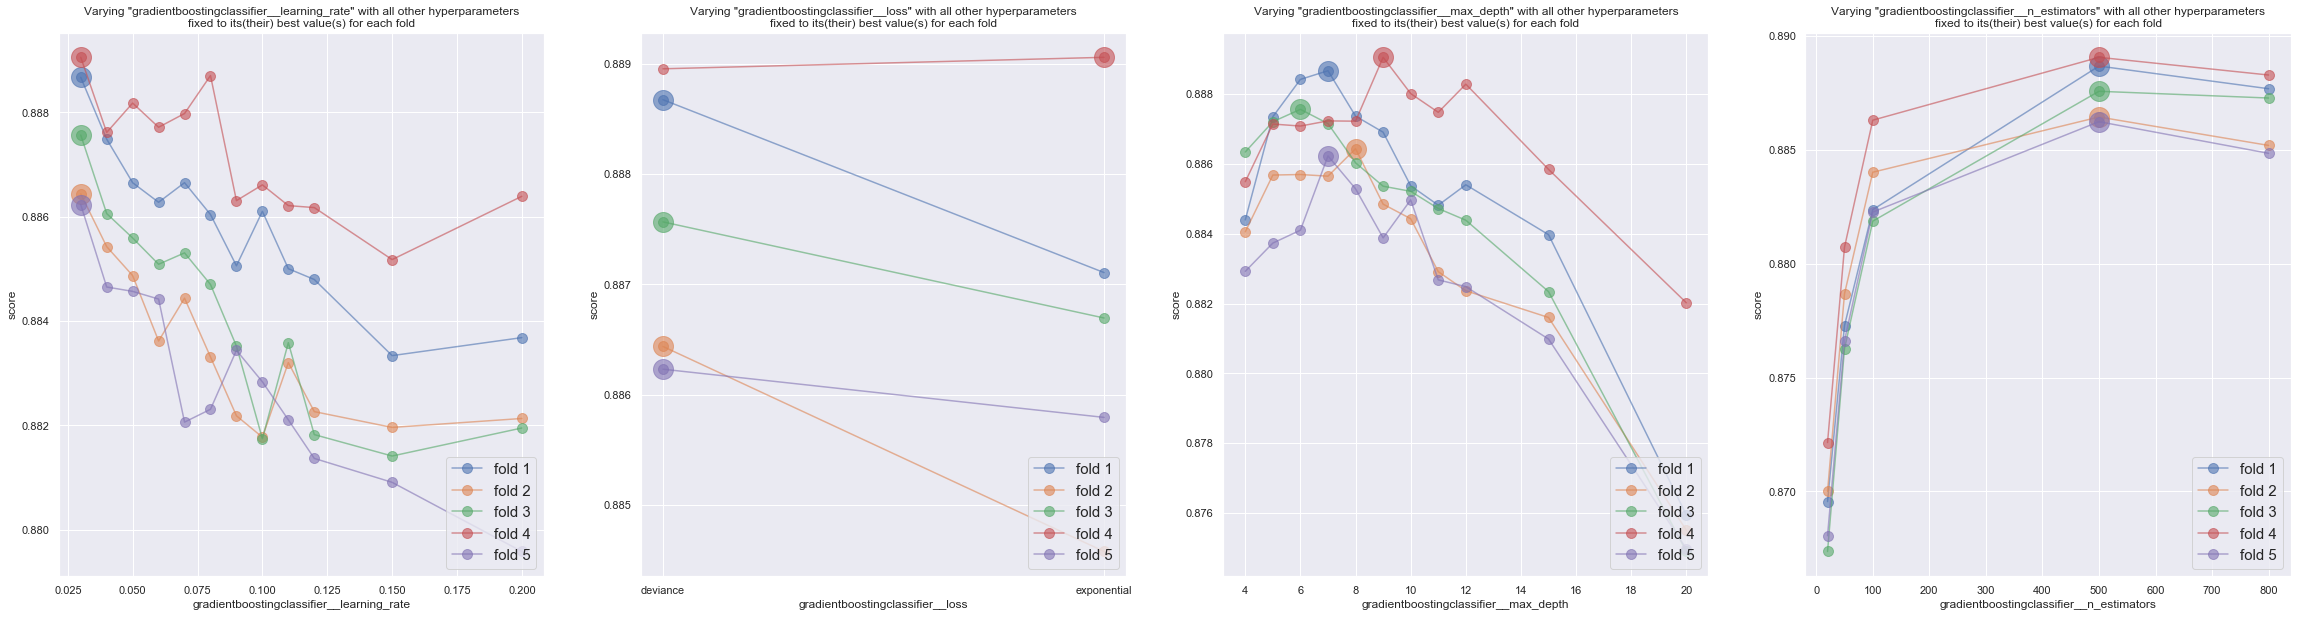

In [46]:
job.metrics.plot_grid_search_results(plot_error_bar = False)

In [47]:
summary.add(job.metrics, 'GradientBoosting', 'darkblue')

Fit model... done! (451.21s)


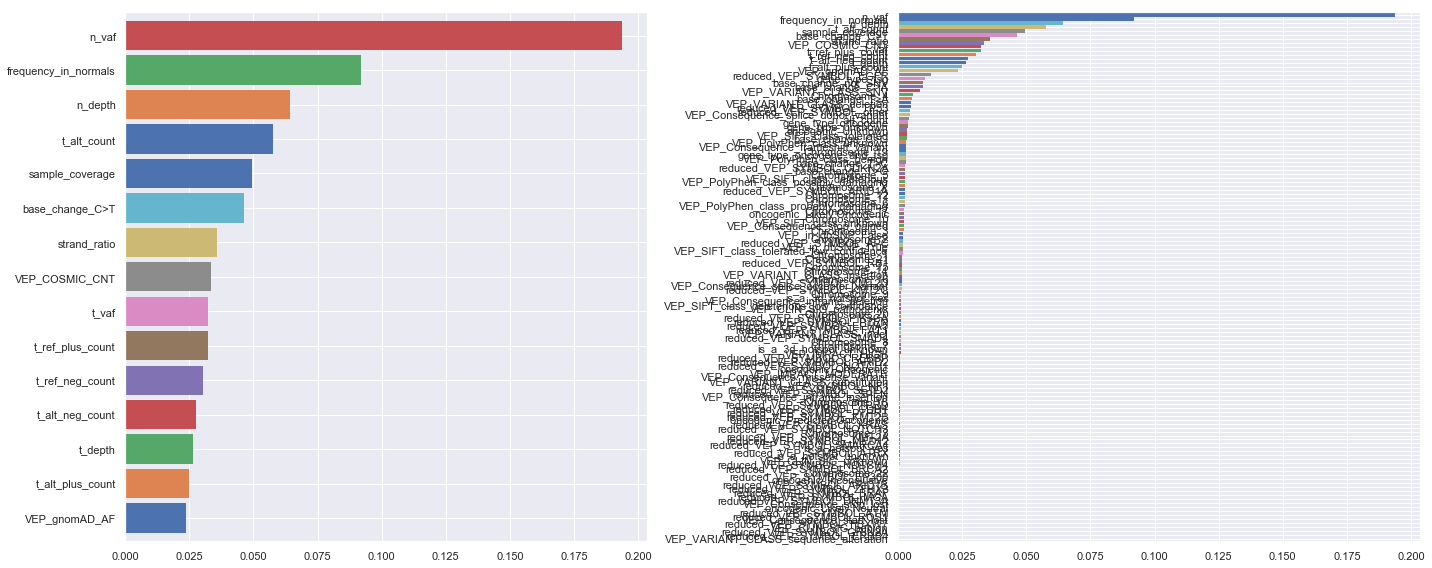

In [63]:
from sklearn.ensemble import GradientBoostingClassifier

model_bestGB = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                             GradientBoostingClassifier(random_state=42, learning_rate=0.1, n_estimators=1000, max_depth=10, loss='deviance'))

metrics = Metrics(model_bestGB, X, y, cv_strategy, n_jobs=5, run_model=False)
metrics.plot_features_importance(random_forest=False, pipeline_step_index=1)

# Summary

In [50]:
summary.save('summaries/final_algorithm_comparison.pkl')

In [54]:
summary = Summary()
summary.load('summaries/final_algorithm_comparison.pkl')

,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
Uniform,0.0304,0.5,0.0304,0.499,0.0573,0.5
MostFrequent,0.0304,0.5,0,0,0,0.97
GausssianNaiveBayes,0.237,0.811,0.373,0.363,0.368,0.962
RidgeRegression,0.399,0.835,0.15,0.631,0.242,0.88
LassoRegression,0.398,0.841,0.175,0.636,0.275,0.894
kNN,0.391,0.854,0.149,0.689,0.245,0.865
SVM,0.376,0.853,0.202,0.664,0.309,0.906
RandomForest,0.506,0.89,0.184,0.73,0.294,0.889
GradientBoosting,0.514,0.892,0.173,0.748,0.281,0.879


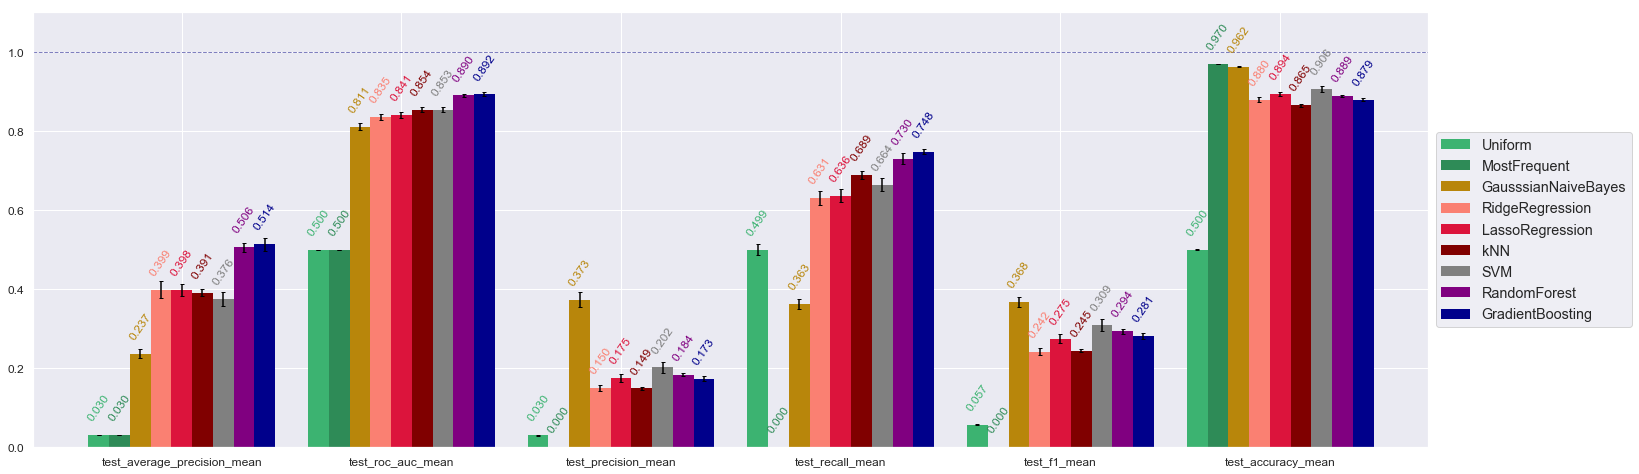

In [51]:
summary.display()
summary.plot()